# Sequential Gausssian Simulation

### Reasoning for building a SGSIM model:
- We want to have a complete spatial model that honors the global distribution and variogram of our data.

Kriging gives the most likely value at each location in a spatial model, and at distances greater than the range, simple kriging assusmes those locations are the global mean of the data. This effect often misses the 
short-range variability and heterogeneity in geospatial data.
- SGSIM corrects for Kriging's low model variance by working in gaussian space, where high values and low values tned not to bunch up. (honors global distribution / histogram)
- SGSIM corrects for Krigings continuous variogram or 'smoothness' (honors spatial variablity)

In [16]:
import os                                                  
import numpy as np                                        
import pandas as pd                                       
import matplotlib.pyplot as plt                           

In [17]:
import geostatspy.geostats as geostats
import geostatspy.GSLIB as GSLIB

Set working directory

In [20]:
os.chdir("/Users/AdrianSalinas/Desktop/resources/CSE Project")                                  

Build a dataframe needed for the SGSIM model using csv formatted data

In [21]:
df = pd.read_csv('sample_data_MV_biased-3.csv')
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000,368.000000
mean,293.260870,499.565217,520.644022,0.597826,0.127026,85.617362,4791.736646
std,169.058258,289.770794,277.412187,0.491004,0.030642,228.362654,974.560569
min,0.000000,0.000000,9.000000,0.000000,0.041122,0.094627,1981.177309
25%,150.500000,240.000000,269.000000,0.000000,0.103412,2.297348,4110.728374
50%,296.000000,500.000000,539.000000,1.000000,0.125842,10.377292,4713.325533
75%,439.500000,762.500000,769.000000,1.000000,0.148623,50.581288,5464.043562
max,586.000000,990.000000,999.000000,1.000000,0.210258,1991.097723,7561.250336


To fully appreciate the model, lets reduce the number of true data points'

In [25]:
df = df.sample(50)
df.describe()

,Unnamed: 0,X,Y,Facies,Porosity,Perm,AI
count,50.000000,50.000000,50.00000,50.000000,50.000000,50.000000,50.000000
mean,302.680000,553.200000,462.46000,0.480000,0.119498,66.154808,5060.942155
std,179.039209,302.212522,292.10616,0.504672,0.030468,192.738309,960.259458
min,21.000000,0.000000,29.00000,0.000000,0.069584,0.262365,3673.832356
25%,162.000000,300.000000,219.00000,0.000000,0.101100,1.796734,4354.446742
50%,284.000000,640.000000,439.00000,0.000000,0.116108,3.330679,4914.500512
75%,472.000000,837.500000,681.50000,1.000000,0.129706,11.941366,5587.577903
max,584.000000,980.000000,999.00000,1.000000,0.200184,931.189014,7561.250336



Lets build a SGSIM model using simple kriging estimator, to do this we will implement the sgsim fuction from
geostatspy library and set the fuction parameter 'ktype' = 0

- By using simple kriging we are not contraining the weights assiged to data to model (as done in ordianry kriging where sum of weight = 1 and the global mean of data does not need to me known, local mean is used instead), and we are working with the residual from the mean. Doing so assumes stationarity in our data i.e. no trends in the data.


 Data for SGSIM: Number of acceptable data     = 50
                 Number trimmed                = 0
                 Weighted Average              = 0.1195
                 Weighted Variance             = 0.0009
                 Weighted Transformed Average  = 0.0023
                 Weighted Transformed Variance = 0.9808
Setting up rotation matrices for variogram and search
Working on realization number 0
   currently on node 0
   currently on node 1000
   currently on node 2000
   currently on node 3000
   currently on node 4000
   currently on node 5000
   currently on node 6000
   currently on node 7000
   currently on node 8000
   currently on node 9000
Reassigning data to nodes

 Realization 0: number   = 10000
                                   mean     = 0.0357 (close to 0.0?)
                                   variance = 0.9628 (close to gammabar(V,V)? approx. 1.0)


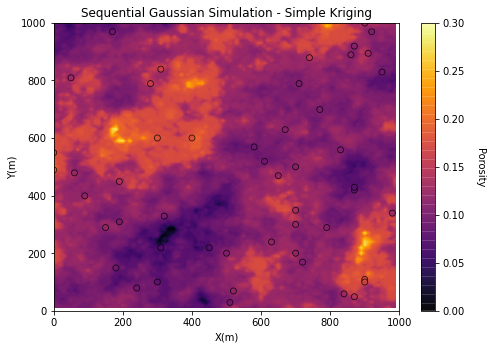

In [40]:
# we are setting our working variables that will be inputs to our sgsim fuction
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 10; radius = 400; skmean = 0

#instatiation of a variogram model with necessary function parameters nugget effect, major & minor ranges, 
#azimuth, etc. 
vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=45.0,hmaj1=300,hmin1=300)

#unsure
tmin = -999; tmax = 999

#SGSIM model
sim_sk = geostats.sgsim(df,'X','Y','Porosity',wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=73073,
            ndmin=ndmin,ndmax=ndmax,nodmax=10,mults=0,nmult=2,noct=-1,radius=radius,radius1=1,sang1=0,
            mxctx=10,mxcty=10,ktype=0,colocorr=0.0,sec_map=0,vario=vario)

#visualize created SGSIM model
xmin = 0.0; xmax = 1000.0; ymin = 0.0; ymax = 1000.0; cmap = plt.cm.inferno
plt.subplot(111)  
GSLIB.locpix_st(sim_sk,xmin,xmax,ymin,ymax,xsiz,0.0,0.30,df,'X','Y','Porosity',
                'Sequential Gaussian Simulation - Simple Kriging','X(m)','Y(m)','Porosity',cmap)
plt.subplots_adjust(left=0.0, bottom=0.0, right=1, top=1, wspace=0.2, hspace=0.2)


In [43]:
# print(type(sim_sk))
# print(sim_sk)
# print((sim_sk.shape))

# Imposed Strategy and Bootsrap

Now that we are able to build a Sequential Gaussian Simulation model, we are going to compare the outcomes between two methods of Bootstrap.

#### Method 1: Standard Bootstrap:

Bootstrap is a means to build an uncertainty distribution for any statsitic by leveraging the scarcity of data. It performs mulitple monte carlo simulations based on the number of available data to build an uncertainty model.

We built a SGSIM model to perform Journelian bootstrap, a method that uses SGSIM models for realizations of the uncertainty model.

We will use Journelian Bootstrap to perform the following workflow:

- Produce a SGSIM model of porosity. This is realization #1.
- from this model, randomly drill n wells using monte carlo simulation from a distibution of locations that span our area of interest.
- from these wells, take the mean of generated mean porosity distribution as a single value for this realization and store it in the global distribution of mean porosity for all realizations.
- repeat this process by genrating a new SGSIM model (realization #2,#3,#n) and repeat for as many times as you have wells to drill. 

We should expect a distribution of mean porosity across n realzations and n wells.

#### Method 2: Bootsrap with Imposed Strategy:

This method will add a stategy to the bootsrap process in method 1. The strategy will implement a predetermined decision criteria that dictates the sampling process in bootsrap.

##### Strategy:

- For each SGSIM realization, drill a well in a random loaction of the porosity map, this is well #1. 
#### If this well is a 'good well' or it exceeds a porosity value determined to be sufficiently high:
-  drill another well (well #2) located in the 'annulus' of well #1. Where the annulus is the annular region surrounding the well defined as the differece between determined radii R1, R2 (R1 > R2). Our intention with a 'good well' outcome is to drill a well close to well #1 (within R1), but not too close (outside R2). 
#### If this well is a 'bad well' or its porosity value is lower than a value determined to be sufficiently low:
- drill well #2 outside of R1 of well #2. Our intention with a 'bad well' outcome is to drill a well far enough away from a bad well to increase the likelihood of drilling a better well with the next drill.

### Assumptions:
With a basic drilling strategy in place, lets discuss some key assumptions that we will make:

#### How close is close? - Determining R1
- In spatial context, We want to honor the variogram of our generated SGSIM model. We do this by assuming R1, the radius of distance that defines the area of 'close' new drills, is equal to the Range of the variogram used to generate the SGSIM model. The range of a variogram is the maximum distance away from a known data location where we can expect to still have information from the known data location to make a prediction. Predicting outside of this range would be naive prediction with regards to the information from the known data location. This is why when we have a good well we drill within the range/R1 to keep the information from the good well, and when we drill a bad well, we drill outside the range/R1 to miminimze the influence of the bad well on our next drill. 



### Questions:
- R1 = range of variogram, what 'variogram' is this?, 'vario' from SGSIM model?